## Preprocessing and cleaning 

In this notebook I explore the dataset and pre process it in order to generate a new dataset. In short the procedure contains
1) The creation of new columns  'Year', 'Month', 'Day', 'Hour', 'Minute', 'Currency Code',	'Rate',	'Amount Paid USD',	'Amount Received USD'
2) Standardise amount in different currencies to USD
 

In [3]:
import pandas as pd 

In [4]:
 df= pd.read_csv('/Users/Malte/code/Malvinrud/aml_detector/HI-Small_Trans.csv')

In [5]:
# Get number of rows
num_rows = len(df)
print("Number of rows: ", num_rows)

Number of rows:  5078345


In [6]:
# Column names and data type
df.dtypes

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object

In [7]:
#How many unique accounts there are
unique_count = df['Account'].nunique()
print('Unique count of Account: ', unique_count)


Unique count of Account:  496995


In [8]:
# Get the distribution of Is Laundering 
laundering_counts = df['Is Laundering'].value_counts(normalize=True)
print(laundering_counts)

Is Laundering
0    0.998981
1    0.001019
Name: proportion, dtype: float64


In [9]:
# Identify Unique Currencies
unique_currencies = df['Payment Currency'].unique()
print(unique_currencies)

['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee' 'Yen'
 'Mexican Peso' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']


In [10]:
# Get the distribution the percentual distribution of flagged transactions by currency 

# Group by payment_currency and Is_Laundering, count the number of rows
distribution = df.groupby(['Payment Currency', 'Is Laundering']).size().reset_index(name='Count')

# Calculate the total counts per currency and name it
total_counts = df.groupby('Payment Currency').size()
total_counts.name = 'Count_total'

# Join the total_counts to the distribution dataframe
distribution = distribution.set_index('Payment Currency').join(total_counts)

# Calculate the percentage
distribution['Percent'] = distribution['Count'] / distribution['Count_total'] * 100

# Reset the index
distribution.reset_index(inplace=True)
print(distribution)

     Payment Currency  Is Laundering    Count  Count_total    Percent
0   Australian Dollar              0   136642       136769  99.907143
1   Australian Dollar              1      127       136769   0.092857
2             Bitcoin              0   146010       146066  99.961661
3             Bitcoin              1       56       146066   0.038339
4         Brazil Real              0    70646        70703  99.919381
5         Brazil Real              1       57        70703   0.080619
6     Canadian Dollar              0   139914       140042  99.908599
7     Canadian Dollar              1      128       140042   0.091401
8                Euro              0  1166925      1168297  99.882564
9                Euro              1     1372      1168297   0.117436
10       Mexican Peso              0   110067       110159  99.916484
11       Mexican Peso              1       92       110159   0.083516
12              Ruble              0   155045       155178  99.914292
13              Rubl

In [11]:
# Convert Timestamp into datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create new columns for year, month, day, hour and minute
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute


In [12]:
# Let's inspect the dataframe
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month,Day,Hour,Minute
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022,9,1,0,20
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022,9,1,0,20
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,2022,9,1,0,0
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,2022,9,1,0,2
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,2022,9,1,0,6


In [13]:
# Now let's standardise the Amounts to US Dollar 

# First let' create a dictionary to map full currency names to their  ISO codes
currency_codes = {
    'Australian Dollar': 'AUD',
    'Bitcoin': 'BTC',
    'Brazil Real': 'BRL',
    'Canadian Dollar': 'CAD',
    'Euro': 'EUR',
    'Mexican Peso': 'MXN',
    'Ruble': 'RUB',
    'Rupee': 'INR',
    'Saudi Riyal': 'SAR',
    'Shekel': 'ILS',
    'Swiss Franc': 'CHF',
    'UK Pound': 'GBP',
    'Yen': 'JPY',
    'Yuan': 'CNY',
    'US Dollar': 'USD'
}

# Replace the full currency names with their codes 
df['Currency Code'] = df['Payment Currency'].replace(currency_codes)


In [14]:
import requests
# Get the exchange rate for all the currencies by connecting to Exchange Rate Data API

# Exchange rate data api key
api_key = "wdiQOxfDckJMZr70O1Brmvlh56iJEfE7"

# Arbitrary date to fetch the exchange rates
date = "2022-09-30"

# The list of currency codes to fetch the exchange rates
currency_codes = ["GBP", "EUR", "AUD", "BTC", "BRL", "CAD", "MXN", "RUB", "INR", "SAR", "ILS", "CHF", "JPY", "CNY"]

# URL
url = f"https://api.apilayer.com/exchangerates_data/{date}?symbols={','.join(currency_codes)}&base=USD"

# Define the headers
headers = {
  "apikey": api_key
}

# Send a GET request to the API
response = requests.get(url, headers=headers)

# Convert the response to JSON
data = response.json()

# Create a DataFrame from the rates
df_rates = pd.DataFrame(data['rates'].items(), columns=['Currency Code', 'Rate'])

# Display the DataFrame
print(df_rates)


   Currency Code        Rate
0            GBP    0.896861
1            EUR    1.019910
2            AUD    1.561524
3            BTC    0.000051
4            BRL    5.412471
5            CAD    1.383270
6            MXN   20.146150
7            RUB   60.203690
8            INR   81.638404
9            SAR    3.756801
10           ILS    3.558540
11           CHF    0.987171
12           JPY  144.739040
13           CNY    7.116041


In [15]:
# Merge df with df_rates on 'Currency Code', preserving all rows from df and filling in NaN for missing match
df = df.merge(df_rates, on='Currency Code', how='left')

# Wherever the rate is NaN, that means the currency was USD. We can fill those with 1.
df['Rate'] = df['Rate'].fillna(1)


In [16]:
# Compute 'Amount Paid USD' and 'Amount Received USD'
df['Amount Paid USD'] = df['Amount Paid'] * df['Rate']
df['Amount Received USD'] = df['Amount Received'] * df['Rate']

In [17]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month,Day,Hour,Minute,Currency Code,Rate,Amount Paid USD,Amount Received USD
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022,9,1,0,20,USD,1.0,3697.34,3697.34
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022,9,1,0,20,USD,1.0,0.01,0.01
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,2022,9,1,0,0,USD,1.0,14675.57,14675.57
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,2022,9,1,0,2,USD,1.0,2806.97,2806.97
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,2022,9,1,0,6,USD,1.0,36682.97,36682.97


In [19]:
#df.to_csv('new_hi_small_trans.csv', index=False)


In [20]:
df_temp = df.head(10000)

In [26]:
! pip install networkx
import networkx as nx
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["Account"].unique(), type='Account')
G.add_nodes_from(df["Account.1"].unique(), type='Account.1')

In [27]:
df["Account"].unique()

array(['8000EBD30', '8000F4580', '8000F4670', ..., '811375C10',
       '8148A6631', '8148A8671'], dtype=object)

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["Account"].unique(), type='Account')
G.add_nodes_from(df["Account.1"].unique(), type='Account.1')

In [28]:
df_temp = df.head(10000)

In [29]:
for _, row in df_temp.iterrows():
    # Create a variable for each properties for each edge
    
        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount_paid = row["Amount Paid USD"],
        currency_code =  row["Currency Code"],
        payment_format = row["Payment Format"]
    
 
        G.add_edge(row['Account'], row['Account.1'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount_paid = amount_paid , currency_code = currency_code ,
              payment_format = payment_format)
  

In [30]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 515080
Number of edges: 10000


In [31]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [32]:
adj_matrix.shape

(515080, 515080)

In [33]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")

Node: 8000EBD30, Properties: Account.1
Node: 8000F4580, Properties: Account
Node: 8000F4670, Properties: Account.1
Node: 8000F5030, Properties: Account.1
Node: 8000F5200, Properties: Account.1
Node: 8000F5AD0, Properties: Account.1
Node: 8000EBAC0, Properties: Account.1
Node: 8000EC1E0, Properties: Account.1
Node: 8000EC280, Properties: Account.1
Node: 8000EDEC0, Properties: Account


In [34]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (20,), 'amount_paid': (3697.34,), 'currency_code': ('USD',), 'payment_format': 'Reinvestment'}}
{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (20,), 'amount_paid': (0.01,), 'currency_code': ('USD',), 'payment_format': 'Cheque'}}
{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (0,), 'amount_paid': (14675.57,), 'currency_code': ('USD',), 'payment_format': 'Reinvestment'}}
{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (2,), 'amount_paid': (2806.97,), 'currency_code': ('USD',), 'payment_format': 'Reinvestment'}}
{0: {'year': (2022,), 'month': (9,), 'day': (1,), 'hour': (0,), 'minute': (6,), 'amount_paid': (36682.97,), 'currency_code': ('USD',), 'payment_format': 'Reinvestment'}}


In [35]:
import collections
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = collections.Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")

In [36]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))


In [37]:
list(edge_list[i][2].values())

[(2022,), (9,), (1,), (0,), (6,), (36682.97,), ('USD',), 'Reinvestment']

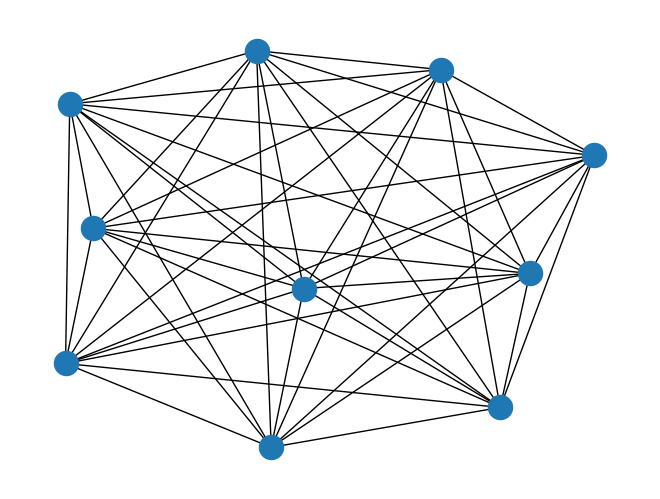

In [38]:
G = nx.complete_graph(sample_nodes)
nx.draw(G)